## Exercice 2 

In [1303]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [1304]:
import folium

We chose Luzern to be the center of our map

In [1305]:
swiss_center = [46.915670, 8.413455]

We create the map centered in Luzern with a zoom start of 8 in order to maximize the size of Switzerland while displaying it entierly.

In [1306]:
m_canton = folium.Map(location=swiss_center,zoom_start=8,tiles='cartodbpositron')

We load our two data files that we will use.
The first one is a TopoJson file that containt topoligical informations about the differents Cantons in order to color them differently in the following tasks.
The second one is an excel file that was generated and downloaded from the amstat website. We choose to import the following features for the month of September 2017 since it is the most recent report available:
 - The unemployement ration per Canton
 - The number of unemployed people per Canton
 - The number of jobseekers
 - The number of jobseekers not unemployed

In [1307]:
topo_path = r'topojson/ch-cantons.topojson.json'
chomage_ratio_path = r'data/Taux_chomage_xl.xlsx'

cho_rat = pd.read_excel(chomage_ratio_path)
topo = json.load(open(topo_path))
cho_rat.head()

,Canton,Mois,Septembre 2017,Septembre 2017.1,Septembre 2017.2,Septembre 2017.3,Total,Total.1,Total.2,Total.3
0,NaN,Mesures,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
1,Zurich,NaN,3.3,27225,34156,6931,3.3,27225,34156,6931
2,Berne,NaN,2.4,13658,18385,4727,2.4,13658,18385,4727
3,Lucerne,NaN,1.7,3885,6756,2871,1.7,3885,6756,2871
4,Uri,NaN,0.6,112,257,145,0.6,112,257,145


Since we are using only one month, it doesn't make sense to keep the "Total" columns.

In [1308]:
colums_to_keep = [col for col in cho_rat.columns if "Total" not in col]
cho_rat = cho_rat[colums_to_keep]

We replace the name of columns [1:] by the values of the first row.
We then drop the first row. We also drop the last raw that represents the total of each columns wich we don't need.

In [1309]:
cho_rat.columns = [np.insert(cho_rat.loc[0].values[1:], [0], 'Cantons')]

cho_rat = cho_rat.drop([0])
cho_rat = cho_rat.drop([len(cho_rat)])

The 'Mesures' columns that contained NaN values is replaced by a 'Month' column with value "September 2017". This is just to keep all the information that was contained in the original data.

In [1310]:
cho_rat = cho_rat.rename(columns = {'Mesures': 'Mois'})
cho_rat['Mois'] = 'Septembre 2017'

In [1311]:
cho_rat.head()

,Cantons,Mois,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
1,Zurich,Septembre 2017,3.3,27225,34156,6931
2,Berne,Septembre 2017,2.4,13658,18385,4727
3,Lucerne,Septembre 2017,1.7,3885,6756,2871
4,Uri,Septembre 2017,0.6,112,257,145
5,Schwyz,Septembre 2017,1.7,1455,2229,774


We translate by hand the values of the columns for convinience of the peer reviewers

In [1313]:
cho_rat = cho_rat.rename(columns = {'Mois': 'Month',
                                   'Taux de chômage': 'Unemployment rate',
                                   'Chômeurs inscrits': 'Registered unemployed',
                                   "Demandeurs d'emploi": "Job seekers",
                                   "Demandeurs d'emploi non chômeurs": 'Employed job seekers'})

We can now calculate the active population based on the Unemployement ration.
The unemployement ration is given by the number of unemployed persons divided by the active population multiplied by 100. Therefore the active population is given by $\frac{\text{Unemployed people}}{\text{Unemployement percentage}} * 100$

In [1314]:
cho_rat['Active population'] = (cho_rat['Registered unemployed'].astype('float')*100/cho_rat['Unemployment rate'].astype('float')).astype('int')
cho_rat.head()

,Cantons,Month,Unemployment rate,Registered unemployed,Job seekers,Employed job seekers,Active population
1,Zurich,Septembre 2017,3.3,27225,34156,6931,825000
2,Berne,Septembre 2017,2.4,13658,18385,4727,569083
3,Lucerne,Septembre 2017,1.7,3885,6756,2871,228529
4,Uri,Septembre 2017,0.6,112,257,145,18666
5,Schwyz,Septembre 2017,1.7,1455,2229,774,85588


We get the Cantons ids from the TopoJson. We will need it for the drawing since the dataframe values for Cantons needs to match the Json values. We could have used the names if we had downloaded  the data in German, but we downloaded it in french therefore the names were differents.

In [1315]:
canton_id = pd.DataFrame(topo['objects']['cantons']['geometries'])['id']

### Unemployement percentage:
This choropleth map represent the percentage of unemployed people wich means the number of unemployed people over the number of active people mulpiplied by hundred, as explained on the amstat website.
    - https://www.amstat.ch/v2/definition.jsp?lang=fr

In [1317]:
sumary_chom = cho_rat[['Cantons', 'Unemployment rate']]
sumary_chom['Unemployment rate'] = sumary_chom['Unemployment rate'].astype('float')
sumary_chom['Cantons'] = canton_id.values
m_canton.choropleth(geo_data=topo, data=sumary_chom,
             columns=['Cantons', 'Unemployment rate'],topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr',
             fill_opacity=0.7,
             line_opacity=0.4,
             legend_name='Unemployement percentage(%)',
             highlight = True)
#m_canton.save('Unemployed.html')
m_canton


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1318]:
cho_rat.head()

,Cantons,Month,Unemployment rate,Registered unemployed,Job seekers,Employed job seekers,Active population
1,Zurich,Septembre 2017,3.3,27225,34156,6931,825000
2,Berne,Septembre 2017,2.4,13658,18385,4727,569083
3,Lucerne,Septembre 2017,1.7,3885,6756,2871,228529
4,Uri,Septembre 2017,0.6,112,257,145,18666
5,Schwyz,Septembre 2017,1.7,1455,2229,774,85588


### Jobseeker Percentage:
Contrary to what was explained on the readme of this homework, the unemployement rate doesn't include the jobseeker that have a job. Therefore we now plot the ratio $\frac{\text{Job seekers}}{\text{Active population}} * 100$

In [1319]:
js_ratio = cho_rat.copy()
js_ratio['Jobseekers ratio'] = cho_rat['Job seekers'].values.astype('float')/cho_rat["Active population"].values.astype('float')*100
js_ratio['Cantons'] = canton_id.values
js_ratio = js_ratio[['Cantons', 'Jobseekers ratio']]
m_canton1 = folium.Map(location=swiss_center,zoom_start=8,tiles='cartodbpositron')
m_canton1.choropleth(geo_data=topo, data=js_ratio,
             columns=['Cantons', 'Jobseekers ratio'],topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr',
             fill_opacity=0.7,
             line_opacity=0.4,
             legend_name='Jobseekers percentage(%)',
             highlight = True)
#m_canton1.save('Jobseekers.html')
m_canton1

### Employed Jobseekers
Notice that the difference between the unemployed people and the jobseekers is exactly the number of jobseekers that are employed. Since this last value is smaller than the two others, it make more sense to plot it by itself.
Therefore we display the ratio $\frac{\text{Employed job seekers}}{\text{Active population}} * 100$

In [1320]:
unstatisfied = cho_rat.copy()
unstatisfied['Employed jobseekers ratio'] = cho_rat['Employed job seekers'].values.astype('float')/cho_rat["Active population"].values.astype('float')*100
unstatisfied['Cantons'] = canton_id.values
unstatisfied = unstatisfied[['Cantons', 'Employed jobseekers ratio']]
m_canton2 = folium.Map(location=swiss_center,zoom_start=8,tiles='cartodbpositron')
m_canton2.choropleth(geo_data=topo, data=unstatisfied,
             columns=['Cantons', 'Employed jobseekers ratio'],topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr',
             fill_opacity=0.7,
             line_opacity=0.4,
             legend_name='Employed jobseekers (%)',
             highlight = True)
#m_canton2.save('Employed_jobseekers.html')
m_canton2

### Discussion
The last map shows more differences, at least we see that it's is not the same distibution as ot was for the unemployement ration.
Let's plot those two ratio side by side to see more easily the differences.

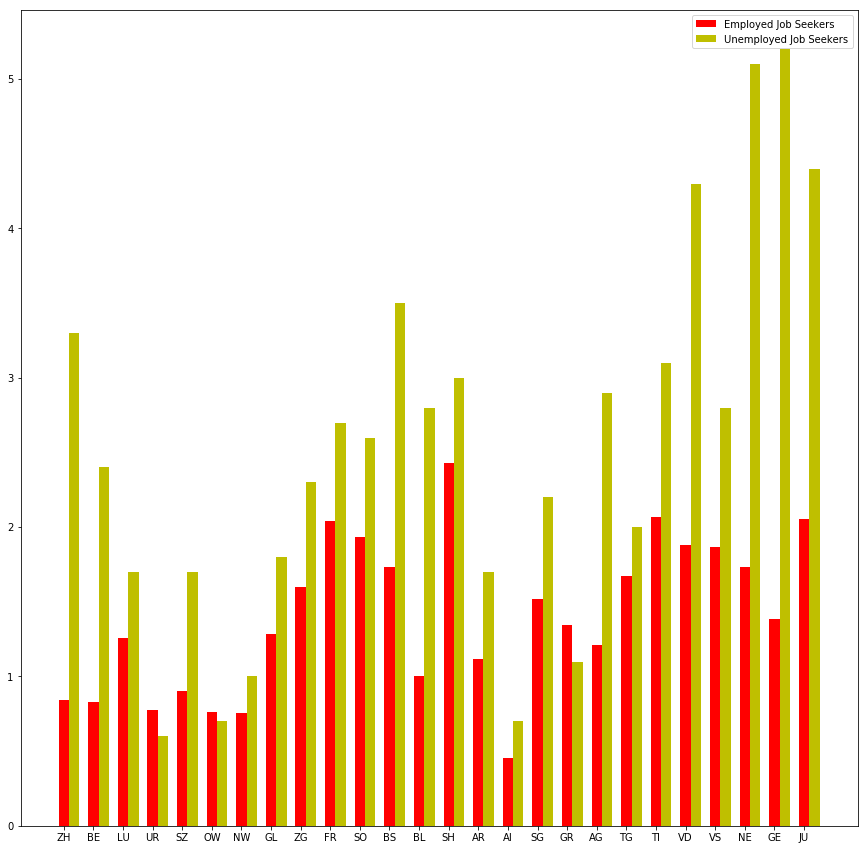

In [1321]:
fig, ax = plt.subplots(figsize=(15,15))
ind = np.arange(len(unstatisfied))  
width = 0.35

rects1 = ax.bar(ind, unstatisfied['Employed jobseekers ratio'].values, width, color='r')
rects2 = ax.bar(ind + width, sumary_chom['Unemployment rate'].values, width, color='y')
ax.legend((rects1[0], rects2[0]), ('Employed Job Seekers', 'Unemployed Job Seekers'))
ax.set_xticklabels(unstatisfied.Cantons.values, minor=False)
ax.set_xticks(np.arange(len(unstatisfied)))

plt.show()

In general both ratio seems to be proportial per Cantons. However we can see different component for Cantons with high unemployement and also Cantons with low unemployements.
As we can see for Cantons with very low ratio of unemployements, the ratio difference is small(i.e UR,OW, NW, AI, GR), contrary to Cantons with high ration of unemployement.(i.e ZH, GE, NE).<br>
Therefore we can imagine a disire of changing of job in Cantons with high unemployement is more risky that is why we don't obeserve a similar proporting for employed job seekers. Whether in Cantons with low unemployement both values are so small that we can just say that the employement situation looks good in those region